In [110]:
from __future__ import division
from scipy.stats import norm
from scipy.optimize import fsolve
from numpy import inf
from math import log, sqrt, exp
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from math import *


def black(cp=None, f=None, k=None, t=None, r=None, v=None, price=None, full=False, comp=inf):
    """ General Purpose BSM machine. Leave one parameter blank and that is the parameter that will
        be solved for.
            cp   = "c" for a call, anything else assumes a put
            f    = Forward Price of the underlying asset
            k    = Strike Price
            t    = Time until maturity (in years)
            r    = Interest rate
            v    = Implied volatility
            comp = How many times interest is compounded a year (default = inf, i.e. continous rates)
            full = If True, function returns a dictionary with price and all sensitivities
                   Otherwise only the calculated/calibrated parameter will be returned
    """

    D1 = lambda f, k, sigma, t: (log(f/k)+(sigma**2/2)*t)/(sigma*sqrt(t))
    D2 = lambda f, k, sigma, t: D1(f, k, sigma, t)-sigma*sqrt(t)

    if comp != inf:
        r = log((1+r/comp)**comp)   # convert rates
    optionType = 1 if cp.upper()[0] == "C" else -1   # If the first letter is not "c" or "C" it must be a put option
    parameters = locals().copy()

    def _black(cp, f, k, t, r, v, price, full, calibration=False, **kwargs):
        d1, d2 = D1(f, k, v, t), D2(f, k, v, t)
#         print(d1, d2)
        price = optionType * exp(-r*t)*(f*norm.cdf(optionType*d1)-k*norm.cdf(optionType*d2))

        if not calibration and full:
            return {
                "price": price,
                "delta": optionType * norm.cdf(optionType*d1),
                "gamma": norm.pdf(d1)/(f*v*sqrt(t)),
                "vega": f*norm.pdf(d1)*sqrt(t)
            }
        else:
            return price

    def _calibrate(value, field, parameters):
        print({field: value[0]})
        parameters.update({field: value[0]})
        return abs(_black(calibration=True, **parameters) - price, )

    missing = [a for a in ["f", "k", "t", "r", "v", "price"] if parameters[a] is None]

    if len(missing) > 1:
        raise Exception("Too many missing variables from: %s " % missing)
    if len(missing) == 0:
        raise Exception("All variables assigned - nothing to solve")

    if missing[0] != "price":
        # if we are missing any parameter different from price we need to calibrate
        result = fsolve(_calibrate, 0.5, args=(missing[0], parameters))

        if full is False:
            return result   # If full=False we simply return the calibrated parameter

    return _black(**parameters)



In [111]:
black("c", k=100, f=103, t=1, r=0.07, price=5)


{'v': 0.5}
{'v': 0.5}
{'v': 0.5}
{'v': 0.5000000074505806}
{'v': 0.08622769663722585}
{'v': 0.0818661463596045}
{'v': 0.09067417239058372}
{'v': 0.0907007140705786}
{'v': 0.09064801467091108}
{'v': 0.0906480138787366}
{'v': 0.09064801387872502}


array([0.09064801])

In [89]:
data = pd.read_pickle("data/BTC-29SEP23-40000-P.pkl")

In [90]:
years_to_maturity = (datetime.datetime(2023, 9, 29) - datetime.datetime.today()).days/365

In [91]:
data.head(5)

,instrument_name,timestamp,underlying_price,mark_iv,mark_price,best_bid_price,best_ask_price,human_timestamp
0,BTC-29SEP23-40000-P,1666437778531,19301.13,61.49,1.1168,0.0,0.0,2022-10-22 14:22:58.531000
8,BTC-29SEP23-40000-P,1666437779537,19301.10,61.49,1.1168,0.0,0.0,2022-10-22 14:22:59.537000
23,BTC-29SEP23-40000-P,1666437780542,19301.10,61.49,1.1168,0.0,0.0,2022-10-22 14:23:00.542000
38,BTC-29SEP23-40000-P,1666437781549,19300.85,61.49,1.1168,0.0,0.0,2022-10-22 14:23:01.549000
54,BTC-29SEP23-40000-P,1666437782556,19300.53,61.49,1.1168,0.0,0.0,2022-10-22 14:23:02.556000


In [92]:
instrument_name = data.iloc[0]["instrument_name"]
option_type = instrument_name[-1]
strike = int(instrument_name[12:17])

In [97]:
ivs = []
for index, row in data.iterrows():
    iv = black(option_type, k = strike, f = row["underlying_price"],
               t = years_to_maturity, r=0.0, price = row["mark_price"])
    ivs.append(iv)
ivs
# почему такой маленький mark_price?

/Users/zugzvangg/Desktop/Projects/crypto-calibration/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[array([-0.06741215]),
 array([-0.0674138]),
 array([-0.0674138]),
 array([-0.06742791]),
 array([-0.06744631]),
 array([-0.06743325]),
 array([-0.06743962]),
 array([-0.06744405]),
 array([-0.06743325]),
 array([-0.06743541]),
 array([-0.06743438]),
 array([-0.06744631]),
 array([-0.06746112])]

In [78]:
black("c",k=100,f=101,t=1,r=0.05,price=5)


array([0.11828237])

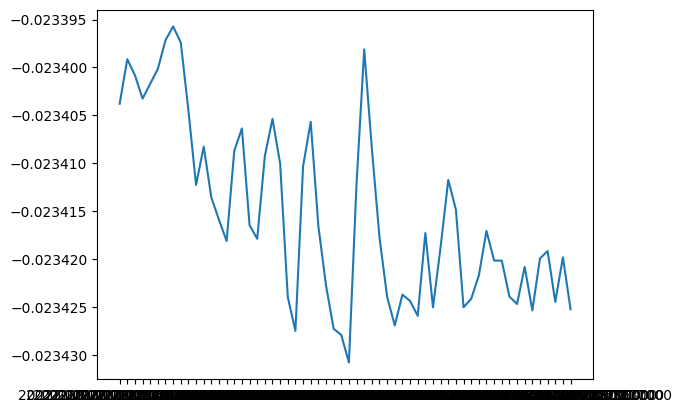

In [77]:
plt.plot(data["human_timestamp"], ivs)